# Notebook II: Policy iteration

In this jupyter notebook we study the policy iteration algorithm and compare its performance with the value function algorithm.

## 1. Cake eating

Recall that the value function in the cake eating example can be solved explicitly (see Section 3.2). We start implementing the utility function and the value function into our notebook for the parameters $\alpha = 0,9$ and $\gamma = 0,5$.   

In [ ]:
gamma=0.5
alpha=0.9

def U(x):
    return x**(1-gamma)/(1-gamma)

def value_fct_cake_eating(x):
    return (1-alpha**(1/gamma))**(-gamma)*U(x)

Recall that in Notebook 1 we have discretized the cake eating problem: we have split the cake with initial size $\bar x$ into $n$ pieces with equal size $\Delta = \frac{\bar x}{n}$. The state space of the discretized problem is $\mathcal{Z} = \{x_0, x_1, \ldots, x_n\}$, where $x_i = i * \Delta$ for all $i \in \{0,1, \ldots, n\}$. The action sets are given by $A(x_i) = \{j*\Delta: 0 \le j \le i\}$.

In the discretized problem one can identify a stationary policy with an integer-valued vector $\pi$ of length $n+1$. We set $\pi_n = j$ if $\pi(x_n) = j* \Delta$. In the state $x_0 =0$ nothing of the cake is left, and hence there is nothing to decide. Thus, only the policy values $\pi_1, \ldots, \pi_n$ are of interest. Moreover, observe that it can not be optimal not to eat at least one unit of the cake. Thus, we can assume that $\pi_n \ge 1$ for all $n \ge 1$.

For each policy $\pi = (\pi_1, \ldots, \pi_n)$ we denote by $J^\pi = (J^\pi_0, \ldots, J^\pi_n)$ the vector with entries $J^\pi_i = J(x_i, \pi)$.

The **policy iteration algorithm** for the cake eating example can be slightly simplied as follows:

1. Choose an arbitrary stationary policy $\pi = (\pi_1, \ldots, \pi_n)$ such that $\pi_n \in \{1, \ldots, n\}$.

2. Determine $J^\pi$ recursively from $0$ to $n$ as follows:
 \begin{align*}
 J^\pi_0 & =  0 \\
 J^\pi_n & = U(\pi_n*\Delta) + \alpha*J^\pi_{n-\pi_n}
 \end{align*}

3. Determine an updated policy $\pi^{new}$ as follows:
\begin{align*}
\pi^{new}_n = \text{argmax}_{a \in \{1, \ldots,n\}} \{ U(a*\Delta) + \alpha*J^\pi_{n-a} \}
\end{align*}

4. If $\pi^{new} \not= \pi$, then set $\pi = \pi^{new}$ and go to 2.

5. If $\pi^{new} = \pi$, then $\pi$ is an optimal policy.   

We now put the algorithm into code. We choose $\bar x = 1$ and $n = 100$. Notice that we also count the number of iterations needed until the updated policy coincides with the previous one.  

In [ ]:
import numpy as np

In [ ]:
xbar = 1
n = 100
Delta = xbar/n


pi = np.ones(n+1)
pi_new = np.zeros(n+1)
J = np.zeros(n+1)
iter = 0
delta = 1

while delta > 0:
    iter = iter+1
    for i in range(1,n+1):
        J[i] = U(Delta*pi[i]) + alpha*J[i-int(pi[i])]
    for i in range(1,n+1):
        pi_new[i] = 1
        for j in range(2,i):
            if (U(Delta*j) + alpha*J[i-j] > U(Delta*pi_new[i]) + alpha*J[i-int(pi_new[i])]):
                pi_new[i] = j
    delta = max(abs(pi- pi_new))
    for i in range(n+1):
        pi[i] = pi_new[i]

print(iter)

9


**Exercise 1.**

Let $\pi_{opti}$ be the optimal policy obtained from the policy iteration algorithm. Compute $V(1) - J^{\pi_{opti}}_n$, i.e. the difference of the true value function at $\bar x = 1$ and the approximated value function from the policy iteration implementation.   

In [ ]:

# Calculate J_opti_n
J_opti_n = J[-1]

# Compute the true value function V(1)
V_1 = value_fct_cake_eating(1)

# Compute the difference between V(1) and J_opti_n
difference = V_1 - J_opti_n
print('error from policy iteration:', difference)




error from policy iteration: 0.04443966635609886


Recall the implementation of the **value function iteration** algorithm from Notebook I:

In [ ]:
def bellman_op(v):
    n = np.size(v)
    v_new = np.zeros(n)
    for i in range(1,n):
        for j in range(i+1):
          v_new[i] = max(v_new[i], U(j*Delta)+alpha*v[i-j])
    return v_new

In [ ]:
xbar = 1
n = 100
Delta = xbar/n

niter = 10

val_fct = np.zeros(n+1)

for t in range(niter):
    val_fct = bellman_op(val_fct)

The difference of the true value function at $\bar x = 1$ and the approximated value function from the value function iteration with 10 steps is computed with the following code:

In [ ]:
print('error from value fct iteration:', abs(val_fct[n]-value_fct_cake_eating(1)))

error from value fct iteration: 0.28850621388300013


Notice that the `error from value fct iteration` is considerably larger than the error from the policy iteration approximation (see Exercise 1).

## 2. Risk taking

We now consider again Example 0.2, Variant 2.

As in Notebook 1 we slightly modify the problem so that the state space becomes finite. We assume that state $100$ is the maximal state and state $-100$ is the minimal state. Moreover, we assume that $-100$, $-99$, $99$ and $100$ are absorbing states. The transition probabilities for arbitrary policies $\pi$ are given by
\begin{align*}
P(\pi)_{ij} = \left\{
\begin{array}{cc}
1 & \text{ if } i=j \text{ and } i,j \in \{-100, -99, 99, 100\}, \\
\frac12 & \text{ if } |i-j| = 1 \text{ and } \pi(i)=1 \text{ and } |i| \le 98, \\
\frac12 & \text{ if } |i-j| = 2 \text{ and } \pi(i)=2 \text{ and } |i| \le 98.
\end{array}\right.
\end{align*}

The policy iteration algorithm for the modified problem is as follows:


1. Choose an initial policy $\pi^0$ and set $n = 0$.

2. Solve the linear equation

\begin{align*}\tag{*}
(\text{Id} - \alpha P(\pi)) y = b
\end{align*}

where $b =(b_{-100}, b_{-99}, \ldots, b_{100}) \in \mathbb{R}^{201}$ is given by
\begin{align*}
b_j = \left\{ \begin{array}{cc}
1, & \text{ if } j \ge 1, \\
0, & \text{ if } j < 0.
\end{array} \right.
\end{align*}
Denote the solution by $V^n$.

3. Choose $\pi^{n+1}$ such that for all $i$ we have

\begin{align}
\pi^{n+1}(i) \in \text{argmax}_{a \in \{1, 2\}} \left\{ 1_{[0, \infty)}(i) + \alpha \sum_{j \in \mathcal{Y}(i,a)} P(\pi^{n+1})_{ij} \ V^n(j) \right\}.
\end{align}

4. If $\pi^{n+1} = \pi^n$, stop. Else set $n = n+1$ and go to 2.  

**Exercise 2.**

a) Write a code that approximates the value function with the policy iteration algorithm. Plot the value function.

b) When you run the code, how many times the policy is updated? Can you explain why the number is so low?

c) Add the expressions `play safe` and `take risk` to the following sentence so that it describes the optimal policy:

... if ahead and ... if behind.   

**Hint:** for solving linear the linear equation (*) you can use the numpy function `np.linalg.solve(A,b)`. The matrix $A$ can be introduced in the notebook with the following code line:

In [ ]:
A = np.eye(201) - alpha*P

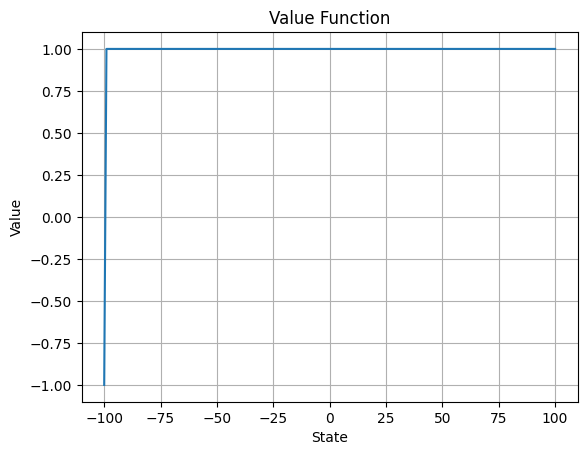

In [ ]:
import numpy as np

def transition_matrix(alpha, pi):
    P_pi = np.zeros((201, 201))
    for i in range(0, 201):
        if i <= 98:
            if pi[i] == 1:
                P_pi[i, i-1] = 0.5
                P_pi[i, i] = 0.5
            elif pi[i] == 2:
                P_pi[i, i-2] = 0.5
                P_pi[i, i] = 0.5
        else:
            P_pi[i, i] = 1
    return  P_pi

def initial_policy():
    return np.ones(201, dtype=int)

def policy_evaluation(alpha, pi, n_iter=1000, tol=1e-6):
    P = transition_matrix(alpha, pi)
    b = np.zeros(201)
    b[1:] = 1  # Set b_j = 1 for j >= 1
    V = np.zeros(201)
    for _ in range(n_iter):
        V_new = np.linalg.solve(P, b)
        if np.max(np.abs(V_new - V)) < tol:
            break
        V = V_new
    return V

def policy_improvement(alpha, V):
    pi_new = np.ones(201, dtype=int)
    for i in range(-100, 101):
        if i >= 0:
            q1 = 1 + alpha * (0.5 * V[i-1] + 0.5 * V[i])
            q2 = 1 + alpha * (0.5 * V[i-2] + 0.5 * V[i])
            if q1 > q2:
                pi_new[i] = 1
            else:
                pi_new[i] = 2
    return pi_new

def policy_iteration(alpha, n_iter=1000, tol=1e-6):
    pi = initial_policy()
    for _ in range(n_iter):
        V = policy_evaluation(alpha, pi)
        pi_new = policy_improvement(alpha, V)
        if np.array_equal(pi_new, pi):
            break
        pi = pi_new
    return V, pi

# Parameters
alpha = 0.9

# Policy iteration
V, pi = policy_iteration(alpha)

# Plot value function
import matplotlib.pyplot as plt

plt.plot(range(-100, 101), V)
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Value Function')
plt.grid(True)
plt.show()


In [ ]:
# Count policy updates
_, pi = policy_iteration(alpha)
policy_updates = np.sum(np.diff(pi) != 0)
print("Number of policy updates:", policy_updates)



Number of policy updates: 3


Optimal policy: if ahead and take risk, take risk, play safe, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, take risk, tak